In [ ]:
!ls drive/MyDrive/

In [ ]:
!cp drive/MyDrive/QA-Polyp-Dataset-2015-train.tar .

In [4]:
!cp drive/MyDrive/QA-Polyp.zip .

In [15]:
!ls

drive  QA-Polyp  QA-Polyp.zip  sample_data


In [ ]:
!tar -xvf QA-Polyp-Dataset-2015-train.tar

In [6]:
!unzip -q QA-Polyp.zip

In [7]:
!ls QA-Polyp/train

0-clear  1-blurry  1-blurry-aug  train.txt


In [ ]:
!ls QA-Polyp/train/1-blurry/ | wc -l

In [ ]:
!mkdir QA-Polyp/train/1-blurry-aug

In [ ]:
!cp QA-Polyp/train/1-blurry/*.png QA-Polyp/train/1-blurry-aug

In [8]:
!ls QA-Polyp/train/1-blurry-aug | wc -l

833


# Data Augmentation for blurry images

In [ ]:
import numpy as np
import os
import cv2


img_list = []
INPUT_PATH = '/content/QA-Polyp/train/1-blurry'

for file in os.listdir(INPUT_PATH):
  img = cv2.imread(INPUT_PATH + '/' + file)
  if img is not None:
    img = cv2.resize(img, (300, 200))
    img_list.append(img)

img_arr = np.asarray(img_list)
img_arr.shape

(233, 200, 300, 3)

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(img_arr[0])

# Horizontal Flip

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

OUTPUT_PATH = '/content/QA-Polyp/train/1-blurry-aug'

datagen = ImageDataGenerator(horizontal_flip=True)
it = datagen.flow(img_arr[:100], batch_size=100)

curr = 0

batch = it.next()
new_img_list = batch.astype('uint8')
for img in new_img_list:
  cv2.imwrite(OUTPUT_PATH + '/img_' + str(curr).zfill(4) + '.png', img)
  curr += 1

# Vertical Flip

In [ ]:
datagen = ImageDataGenerator(vertical_flip=True)
it = datagen.flow(img_arr[100:200], batch_size=100)

batch = it.next()
new_img_list = batch.astype('uint8')
for img in new_img_list:
  cv2.imwrite(OUTPUT_PATH + '/img_' + str(curr).zfill(4) + '.png', img)
  curr += 1

# Random Rotation

In [ ]:
curr = 200

In [ ]:
datagen = ImageDataGenerator(rotation_range=90)
it = datagen.flow(img_arr, batch_size=200)

batch = it.next()
new_img_list = batch.astype('uint8')
for img in new_img_list:
  cv2.imwrite(OUTPUT_PATH + '/img_' + str(curr).zfill(4) + '.png', img)
  curr += 1

In [ ]:
curr

400

In [ ]:
!ls QA-Polyp/train/1-blurry-aug

In [ ]:
!rm QA-Polyp/train/1-blurry-aug/img_02*
!rm QA-Polyp/train/1-blurry-aug/img_03*

# Random brightness

In [ ]:
datagen = ImageDataGenerator(brightness_range=[0.5, 1.5])
it = datagen.flow(img_arr, batch_size=100)

batch = it.next()
new_img_list = batch.astype('uint8')
for img in new_img_list:
  cv2.imwrite(OUTPUT_PATH + '/img_' + str(curr).zfill(4) + '.png', img)
  curr += 1

# Random zoom

In [ ]:
datagen = ImageDataGenerator(zoom_range=[0.5, 1.5])
it = datagen.flow(img_arr, batch_size=100)

batch = it.next()
new_img_list = batch.astype('uint8')
for img in new_img_list:
  cv2.imwrite(OUTPUT_PATH + '/img_' + str(curr).zfill(4) + '.png', img)
  curr += 1

In [ ]:
!zip -r QA-Polyp.zip QA-Polyp/

In [ ]:
!cp QA-Polyp.zip drive/MyDrive

In [10]:
import numpy as np
import os
import cv2

INPUT_PATH = '/content/QA-Polyp/train/1-blurry'

input_list = []
label_list = []
INPUT_PATH = '/content/QA-Polyp/train'

for file in os.listdir(INPUT_PATH + '/0-clear'):
  img = cv2.imread(INPUT_PATH + '/0-clear/' + file)
  if img is not None:
    img = cv2.resize(img, (300, 200))
    input_list.append(img)
    label_list.append(0)

for file in os.listdir(INPUT_PATH + '/1-blurry-aug'):
  img = cv2.imread(INPUT_PATH + '/1-blurry-aug/' + file)
  if img is not None:
    img = cv2.resize(img, (300, 200))
    input_list.append(img)
    label_list.append(1)

input_arr = np.array(input_list)
label_arr = np.array(label_list)

In [11]:
print(input_arr.shape)
print(label_arr.shape)

(1662, 200, 300, 3)
(1662,)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_arr, label_arr, test_size=0.3, random_state=42)
print(X_train.shape)

(1163, 200, 300, 3)


In [13]:
acc_per_fold = []
loss_per_fold = []

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
# import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
for train, test in kfold.split(input_arr, label_arr):
  resnet_model = Sequential()

  pretrained_model= EfficientNetB0(include_top=False,
                    input_shape=(200, 300, 3),
                    pooling='avg',classes=2,
                    weights='imagenet')
  for layer in pretrained_model.layers:
          layer.trainable=False

  resnet_model.add(pretrained_model)

  resnet_model.add(Flatten())
  resnet_model.add(Dense(512, activation='relu'))
  resnet_model.add(Dense(1, activation='sigmoid'))
  resnet_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

  history = resnet_model.fit(input_arr[train], label_arr[train], epochs=20)

  scores = resnet_model.evaluate(input_arr[test], label_arr[test])
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

In [16]:
print(acc_per_fold)

[96.99699878692627, 97.29729890823364, 96.6867446899414, 96.08433842658997, 97.28915691375732]


In [17]:
pred = resnet_model.predict(X_test)

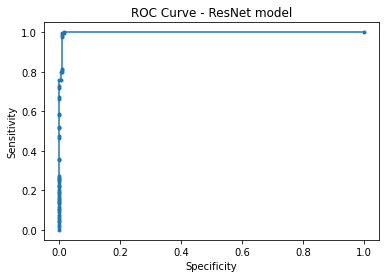

In [18]:
from matplotlib import pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, pred)

auc_keras = auc(fpr, tpr)
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
plt.title("ROC Curve - EfficientNet model")
plt.plot(fpr, tpr, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [19]:
print('roc_auc_score : ', roc_auc_score(y_test, pred))

roc_auc_score :  0.9981338481338481
